#### Create score distribution exhibits for CIS189.



In [4]:

from random import sample
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Configuration ----------------------------------------------------------------

csv_path = "G:/My Drive/CIS189/Spring-2024-CIS189-Grades.csv"
module = 12

# ------------------------------------------------------------------------------

dfall = pd.read_csv(csv_path)

df = dfall[dfall.module==module].reset_index(drop=True)

print(df.shape)


df.head(10)


(24, 7)


,last,first,module,assignment,desc,possible,grade
0,Barrette,Virginia,12,1,CSV import into class object,10.0,5.0
1,Begnoche,Bradley,12,1,CSV import into class object,10.0,6.0
2,Boichenko,Yullia,12,1,CSV import into class object,10.0,0.0
3,Deam,Alexander,12,1,CSV import into class object,10.0,10.0
4,Freel,Kieron,12,1,CSV import into class object,10.0,7.0
5,Gambarrotti,Manny,12,1,CSV import into class object,10.0,5.0
6,Hoeflick,Adam,12,1,CSV import into class object,10.0,6.0
7,Marhocevic,Muhammed,12,1,CSV import into class object,10.0,0.0
8,Mueller,Javin,12,1,CSV import into class object,10.0,6.0
9,Oakes,Calvin,12,1,CSV import into class object,10.0,8.0


In [2]:


dfassign = df[["module", "assignment", "desc", "possible"]].drop_duplicates()

# Get number of NAs for current module assignments. 
dfna = (
    df
    .groupby(["module", "assignment"])
    .count()
    .rsub(df.groupby("assignment").size(), axis=0)["grade"]
    .reset_index(drop=False)
    .rename({"grade": "missing"}, axis=1)
    )

# Merge dfassin with dfna. 
dfassign = dfassign.merge(dfna, on=["module", "assignment"], how="left")

dfassign.head()


,module,assignment,desc,possible,missing
0,12,1,CSV import into class object,10.0,0
1,12,2,abstract class,20.0,0


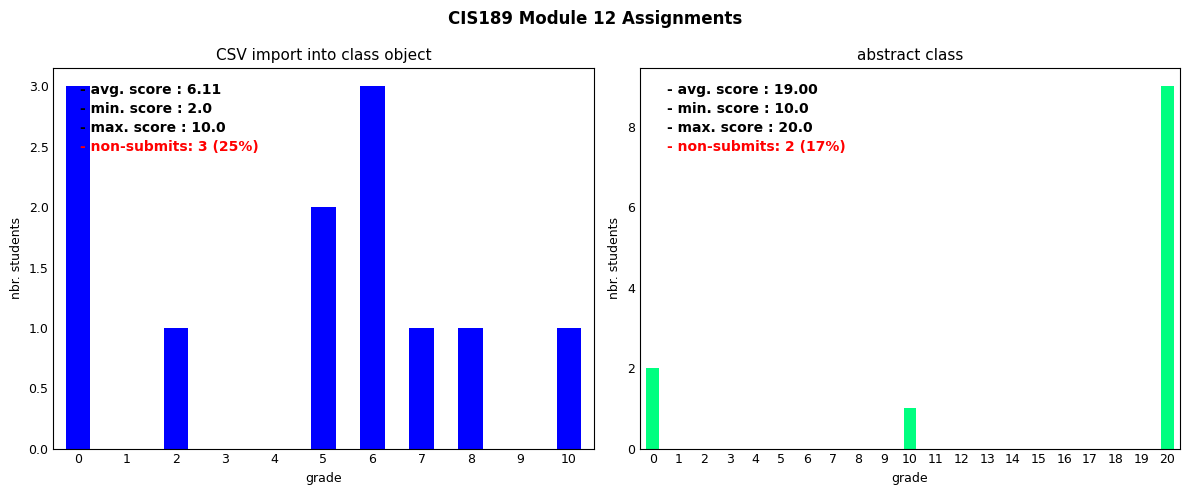

In [3]:

# color = "#E02C70"
cmap = "winter" #"gist_rainbow" #"winter"


n_facets = dfassign.shape[0]
fcolors = mpl.colormaps.get_cmap(cmap)
colors_rgba = [fcolors(ii) for ii in np.linspace(0, 1, n_facets)]
colors_hex = [mpl.colors.to_hex(ii, keep_alpha=False) for ii in colors_rgba]


fig, ax = plt.subplots(1, n_facets, figsize=(12, 5.0), sharey=False, sharex=False, tight_layout=True) 

for ii, color in enumerate(colors_hex):
    module = dfassign.at[ii, "module"]
    assign = dfassign.at[ii, "assignment"]
    desc = dfassign.at[ii, "desc"]
    possible = dfassign.at[ii, "possible"]
    nbr_students = df[(df.module==module) & (df.assignment==assign)].shape[0]
    dfgrades = pd.DataFrame(np.arange(0, possible + 1, dtype=int), columns=["grade"])
    gg = df[df.assignment==assign].fillna(0).groupby("grade", as_index=False).size()
    gg = dfgrades.merge(gg, on="grade", how="left").fillna(0).rename({"size": "n"}, axis=1)
    zs = int(gg[gg.grade==0]["n"].item())
    dfavg = gg[gg.grade!=0]
    avg_score = (dfavg.grade * dfavg.n).sum() / dfavg.n.sum()
    min_score = df[(df.assignment==assign) & (df.grade>0)]["grade"].min().item()
    max_score = df[df.assignment==assign].dropna(how="any")["grade"].max()
    gg = gg.assign(grade=gg["grade"].astype(str), n=gg["n"].astype(int))
    gg.plot.bar(ax=ax[ii], color=color)
    
    ax[ii].set_title(f"{desc}", fontsize=11, weight="normal")
    ax[ii].set_xticklabels(gg["grade"].values, rotation=0)
    ax[ii].set_xlabel("grade", fontsize=9)
    ax[ii].set_ylabel("nbr. students", fontsize=9)
    ax[ii].tick_params(axis="x", which="major", direction='in', labelsize=9)
    ax[ii].tick_params(axis="y", which="major", direction='in', labelsize=9)
    ax[ii].xaxis.set_ticks_position("none")
    ax[ii].yaxis.set_ticks_position("none")

    missing = int(gg[gg.grade=="0"]["n"].item())
    prop_missing = missing / nbr_students
    avg_desc = f"- avg. score : {avg_score:.2f}"
    min_desc = f"- min. score : {min_score:.1f}"
    max_desc = f"- max. score : {max_score:.1f}"
    na_desc  = f"- non-submits: {missing} ({prop_missing:.0%})"

    ax[ii].annotate(
        avg_desc, xy=(.05, .925), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=10, rotation=0, weight="bold", color="#000000"
        ) 
    ax[ii].annotate(
        min_desc, xy=(.05, .875), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=10, rotation=0, weight="bold", color="#000000"
        ) 
    ax[ii].annotate(
        max_desc, xy=(.05, .825), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=10, rotation=0, weight="bold", color="#000000"
        ) 
    ax[ii].annotate(
        na_desc, xy=(.05, .775), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=10, rotation=0, weight="bold", color="#FF0000"
        ) 
    ax[ii].get_legend().remove()


plt.suptitle(f"CIS189 Module {module} Assignments", weight="bold", size=12)
plt.show()
